# no-use (a try using numerical case)

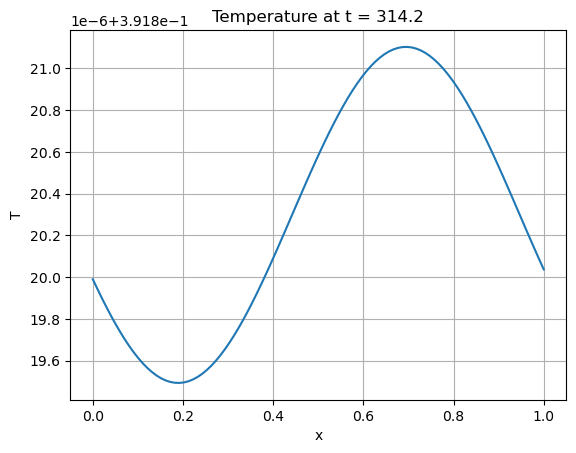

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
u = 1.0
L = 1.0
Nx = 100
dx = L / Nx

N_pi = 400
dt = np.pi / N_pi
Nt = 200 * N_pi
T_total = 200 * np.pi

# 网格初始化
x = np.linspace(0, L, Nx)
T = np.exp(-((x - 0.5)**2) * 20)  # 更平滑的初始条件
T_new = np.zeros_like(T)

# 用于保存所有时间步的 T(x, t)
T_all = np.zeros((Nt, Nx))

# 时间推进 + 保存
for n in range(Nt):
    t_n = n * dt
    T_new[0] = T[0] - u * dt / dx * (T[0] - T[-1]) + dt * np.sin(t_n)
    for i in range(1, Nx):
        T_new[i] = T[i] - u * dt / dx * (T[i] - T[i-1]) + dt * np.sin(t_n)
    T[:] = T_new[:]
    T_all[n, :] = T  # 保存当前时间步的温度分布

# 可视化某个时间切片
plt.plot(x, T_all[Nt//2])
plt.xlabel('x')
plt.ylabel('T')
plt.title(f'Temperature at t = {T_total/2:.1f}')
plt.grid()
plt.show()


# from here! 
# 1d analytical case for testing the role of resolution in the watermass budget

#  analytical 

In [3]:
import numpy as np

dt = 0.01
dx = 0.02
t = np.arange(1,41.,dt)
x = np.arange(0,3.02,dx)
x2, t2 = np.meshgrid(x, t)

T = 0.1/np.pi * np.cos(np.pi*t2) + 1/np.pi * np.cos(np.pi/3*t2) + np.sin(0.3*np.pi*(x2-t2)) + np.sin(0.7*np.pi*(x2-t2)) + 1
Tdot = -0.1 * np.sin(np.pi*t2) - 1/3. * np.sin(np.pi/3*t2)
Tx = 0.3*np.pi*np.cos(0.3*np.pi*(x2-t2)) + 0.7*np.pi*np.cos(0.7*np.pi*(x2-t2))

yearlyNt = int(2*np.pi/np.pi/dt )
nyear = int( len(t)/yearlyNt )


# interp to finer resolution

In [4]:
from scipy.interpolate import interp1d

# 新的更高分辨率网格
dx_new = 0.002
x_new = np.arange(0, 3.001, dx_new)

# 矢量化插值 (沿x方向)
f_T = interp1d(x, T, axis=1, kind='linear', fill_value='extrapolate')
f_Tdot = interp1d(x, Tdot, axis=1, kind='linear', fill_value='extrapolate')
f_Tx = interp1d(x, Tx, axis=1, kind='linear', fill_value='extrapolate')

T_new = f_T(x_new)
Tdot_new = f_Tdot(x_new)
Tx_new = f_Tx(x_new)

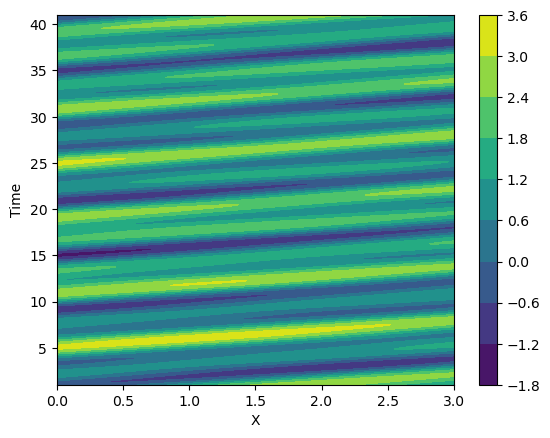

In [7]:
import matplotlib.pyplot as plt
plt.contourf(x2,t2, T)
plt.ylabel('Time')
plt.xlabel('X')
plt.colorbar()

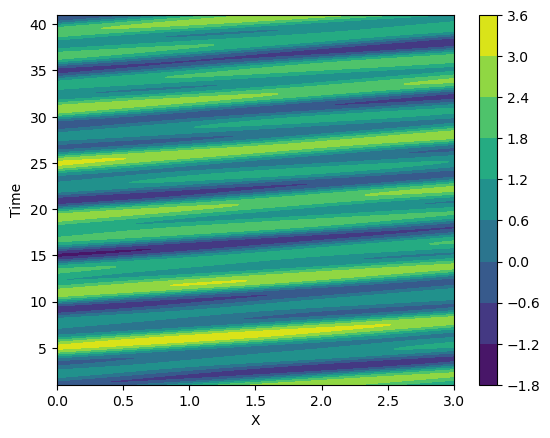

In [6]:
import matplotlib.pyplot as plt
x2_new, t2_new = np.meshgrid(x_new, t)

plt.contourf(x2_new,t2_new, T_new)
plt.ylabel('Time')
plt.xlabel('X')
plt.colorbar()

## method mask
### original data

In [8]:
dtcenters = 0.01
tcneters = np.arange(-1,3.1,dtcenters)

dmdt = np.zeros([len(tcneters),len(t)])
M    = np.zeros([len(tcneters),len(t)])
gmat = np.zeros([len(tcneters),len(t)])
gadv = np.zeros([len(tcneters),len(t)])
gadv_left = np.zeros([len(tcneters),len(t)])
gadv_right = np.zeros([len(tcneters),len(t)])

for i in range( len(tcneters) ):
    
    M[i,:] = (T >= tcneters[i]).sum(axis=1)*dx   #Tprime shape (ntime,nx)
    
    # transformation
    mask2 = (T >= tcneters[i]+dtcenters) & (x2 <= 3)      # shape (ntime, nx), 
    Tdotmasked = np.where(mask2, Tdot, 0.0)
    mat2 = (Tdotmasked*dx).sum(axis=1)   # shape (ntime,)    

    mask1 = (T >= tcneters[i]-dtcenters) & (x2 <= 3)       # shape (ntime, nx), 
    Tdotmasked = np.where(mask1, Tdot, 0.0)
    mat1 = (Tdotmasked*dx).sum(axis=1)   # shape (ntime,)   

    gmat[i,:] = -(mat2-mat1)/(2*dtcenters)

    # adv
    leftmask = (T >= tcneters[i]) & (x2 == 0) 
    uu = np.ones(T.shape)
    gadv_left = (-uu*leftmask*1.).sum(axis=1)
    
    rightmask = (T >= tcneters[i]) & (x2 == 3) 
    gadv_right = (-uu*rightmask*1.).sum(axis=1)
    
    gadv[i,:] = gadv_right - gadv_left
    
dmdt = (M[:,2:]-M[:,0:-2])/dt/2.


## method mask
### high-resolution data

In [6]:
dtcenters = 0.01
tcneters = np.arange(-1,3.1,dtcenters)

x2_new, t2_new = np.meshgrid(x_new, t)


dmdt_new = np.zeros([len(tcneters),len(t)])
M_new    = np.zeros([len(tcneters),len(t)])
gmat_new = np.zeros([len(tcneters),len(t)])
gadv_new = np.zeros([len(tcneters),len(t)])
gadv_left_new = np.zeros([len(tcneters),len(t)])
gadv_right_new = np.zeros([len(tcneters),len(t)])

for i in range( len(tcneters) ):
    
    M_new[i,:] = (T_new >= tcneters[i]).sum(axis=1)*dx_new   #Tprime shape (ntime,nx)
    
    # transformation
    mask2 = (T_new >= tcneters[i]+dtcenters) & (x2_new <= 3)      # shape (ntime, nx), 
    Tdotmasked = np.where(mask2, Tdot_new, 0.0)
    mat2 = (Tdotmasked*dx_new).sum(axis=1)   # shape (ntime,)    

    mask1 = (T_new >= tcneters[i]-dtcenters) & (x2_new <= 3)       # shape (ntime, nx), 
    Tdotmasked = np.where(mask1, Tdot_new, 0.0)
    mat1 = (Tdotmasked*dx_new).sum(axis=1)   # shape (ntime,)   

    gmat_new[i,:] = -(mat2-mat1)/(2*dtcenters)

    # adv
    leftmask = (T_new >= tcneters[i]) & (x2_new == 0) 
    uu = np.ones(T_new.shape)
    gadv_left = (-uu*leftmask*1.).sum(axis=1)
    
    rightmask = (T_new >= tcneters[i]) & (x2_new == 3) 
    gadv_right = (-uu*rightmask*1.).sum(axis=1)
    
    gadv_new[i,:] = gadv_right - gadv_left
    
dmdt_new = (M_new[:,2:]-M_new[:,0:-2])/dt/2.

## method2 - using transform

In [7]:
dtcenters = 0.01
tcneters = np.arange(-1,3.1,dtcenters)

bins = np.concatenate([tcneters - dtcenters/2, [tcneters[-1] + dtcenters/2]])


dmdt = np.zeros([len(tcneters),len(t)])
M    = np.zeros([len(tcneters),len(t)])
gmat = np.zeros([len(tcneters),len(t)])
gadv = np.zeros([len(tcneters),len(t)])
gadv_left = np.zeros([len(tcneters),len(t)])
gadv_right = np.zeros([len(tcneters),len(t)])

for it in range(len(t)):
    M[:, it] = np.histogram(T[it,:], bins=bins)[0]* dx
    mat = np.histogram(T[it,:], bins=bins, weights=Tdot[it,:]*dx)[0]
    gmat[:, it] = -mat / dtcenters   # 近似 ∂/∂T
    gadv_left[:, it]  = np.histogram(T[it, x==0], bins=bins, weights=-uu[it, x==0])[0]
    gadv_right[:, it] = np.histogram(T[it, x==3], bins=bins, weights= uu[it, x==3])[0]
    gadv[:, it] = -gadv_left[:, it] + gadv_right[:, it]

#dmdt = (M[:,2:] - M[:,:-2])/(2*dt)
dmdt = (M[:,1:] - M[:,:-1])/dt







IndexError: boolean index did not match indexed array along dimension 1; dimension is 1501 but corresponding boolean dimension is 151

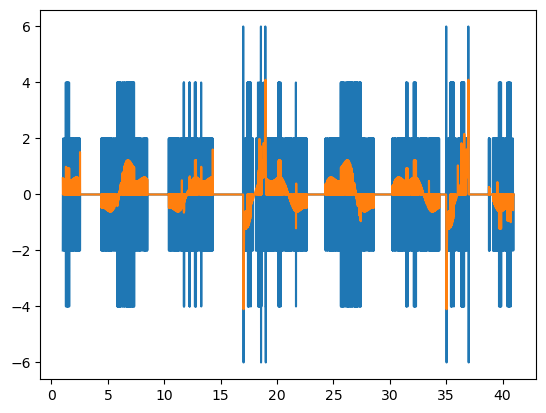

In [16]:
import matplotlib.pyplot as plt

plt.plot(t[:-1], dmdt[300,:],label='dMdt')
plt.plot(t[:-1], gmat[300,:-1]+gadv[300,:-1] ,label='gmat')


# testing different time derivative method

In [9]:
import numpy as np

def time_derivative(f, dt, order=2):
    """
    f: 2D numpy array, shape (n, ntime)
       n = 空间点数，ntime = 时间长度
    dt: 时间步长 (float)
    order: 差分阶数 (2, 4, 6)
    return: df/dt (二维数组), 有效时间索引
    """
    if order == 2:
        # 二阶中心差分
        dfdt = (f[:, 2:] - f[:, :-2]) / (2 * dt)
        t_idx = np.arange(1, f.shape[1]-1)

    elif order == 4:
        # 四阶中心差分
        dfdt = (-f[:, 4:] + 8*f[:, 3:-1] - 8*f[:, 1:-3] + f[:, :-4]) / (12 * dt)
        t_idx = np.arange(2, f.shape[1]-2)
    elif order == 6:
        dfdt = (-f[:, :-6] + 9*f[:, 1:-5] - 45*f[:, 2:-4] 
            + 45*f[:, 4:-2] - 9*f[:, 5:-1] + f[:, 6:]) / (60*dt)
        t_idx = np.arange(3, f.shape[1]-3)

    else:
        raise ValueError("只支持 order=2, 4, 6")
    
    return dfdt, t_idx

dmdt2, t2 = time_derivative(M, dt, order=2)  # shape (100, 48)
dmdt4, t4 = time_derivative(M, dt, order=4)  # shape (100, 46)
dmdt6, t6 = time_derivative(M, dt, order=6)  # shape (100, 44)

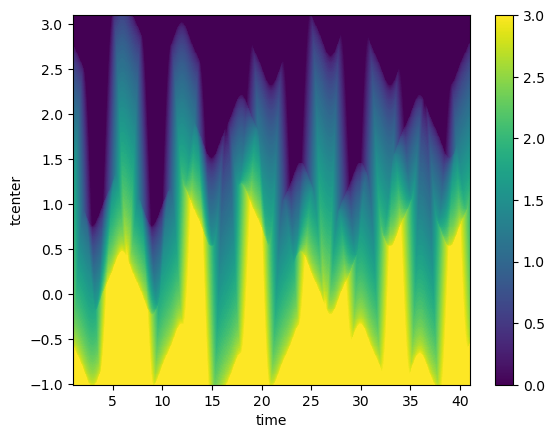

In [11]:
import matplotlib.pyplot as plt
xx2, tt2 = np.meshgrid(t, tcneters)

plt.pcolor(xx2, tt2, M, vmin=0, vmax=3)
plt.xlabel('time')
plt.ylabel('tcenter')
plt.colorbar()


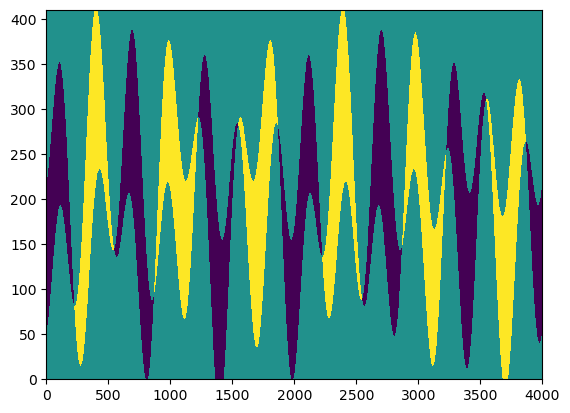

In [12]:
plt.pcolor(gadv)

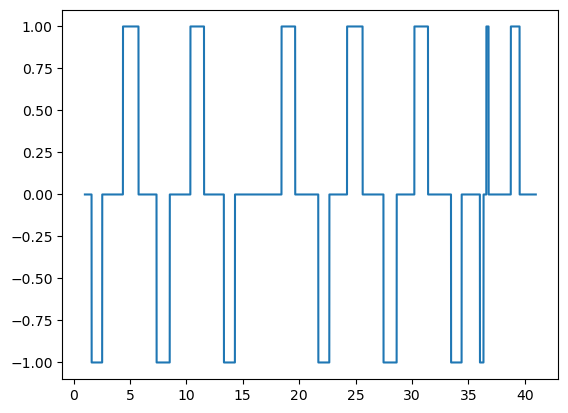

In [59]:
plt.plot(t[0:-1], gadv[30,0:-1])

(0.1, 0.5)

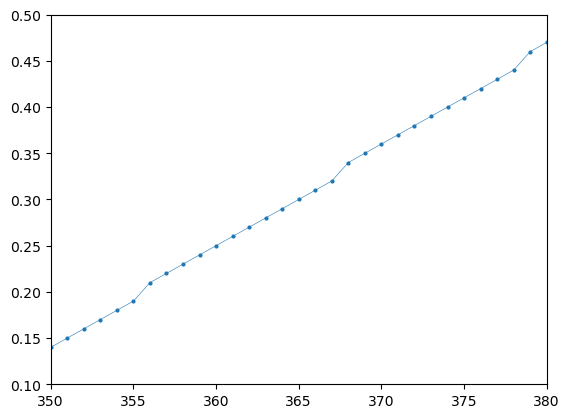

In [100]:
plt.plot(M[300,:], ".-", markersize=4, lw=0.4)
plt.xlim(350, 380)
plt.ylim(0.1, 0.5)

(300.0, 600.0)

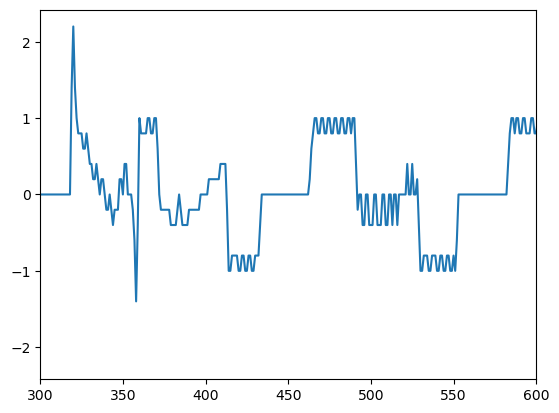

In [19]:
plt.plot(dmdt[300,:])
plt.xlim(300, 600)

(300.0, 600.0)

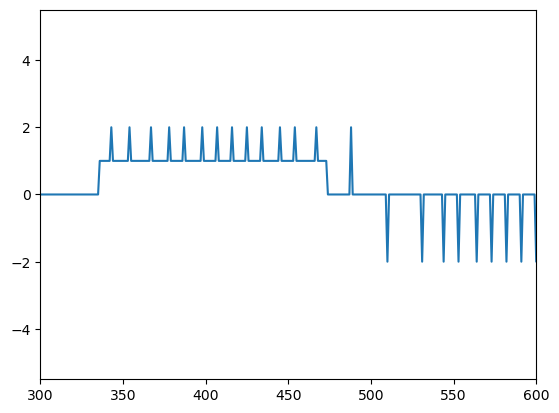

In [12]:
plt.plot(dmdt[300,:])
plt.xlim(300, 600)

In [16]:
print(tcneters[0])

-1.0


In [18]:
T.min()

-1.35014087480217

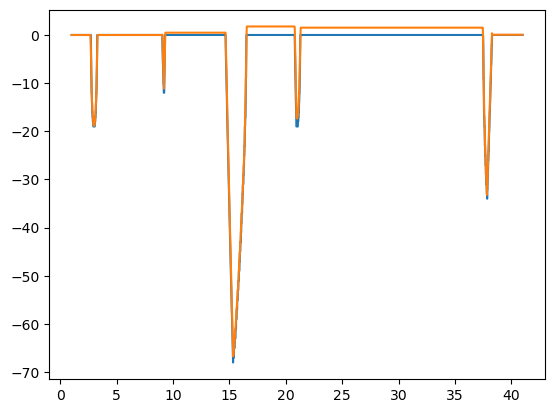

In [17]:
plt.plot(t[t2], np.cumsum( dmdt[0,]),label='dMdt')
plt.plot(t[t2], np.cumsum( gmat[0,t2]+gadv[0,t2]),label='gmat')

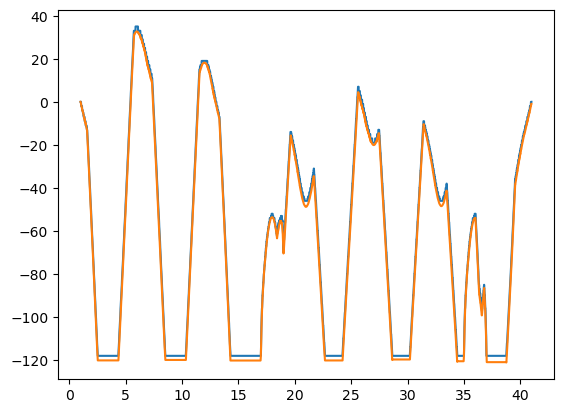

In [16]:
plt.plot(t[t2], np.cumsum(dmdt[300,]),label='dMdt')
plt.plot(t[t2], np.cumsum( gmat[300,t2]+gadv[300,t2]),label='gmat')

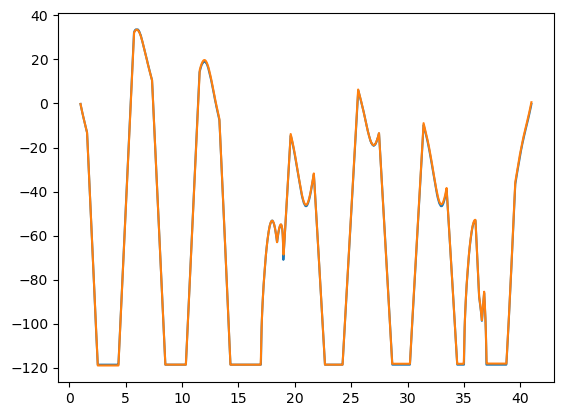

In [30]:
plt.plot(t[t2], np.cumsum(dmdt_new[300,]),label='dMdt')
plt.plot(t[t2], np.cumsum( gmat_new[300,t2]+gadv_new[300,t2]),label='gmat')

(-1.5, 1.5)

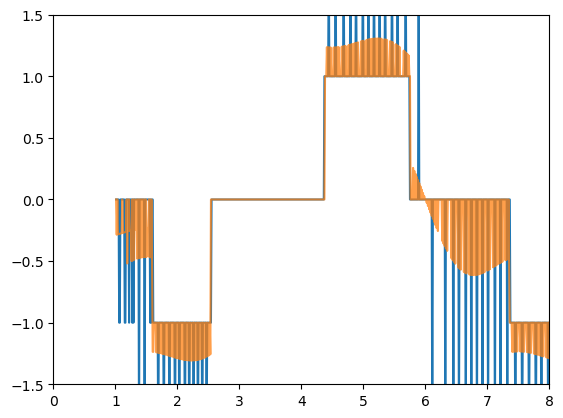

In [24]:
import matplotlib.pyplot as plt

plt.plot(t[t2], dmdt2[300,:],label='dMdt')
#plt.plot( gmat[30,0:200]+gadv[30,0:200],label='rhs')
plt.plot(t[t2], gmat[300,t2]+gadv[300,t2] ,label='gmat',alpha=0.75)

plt.xlim(0,8)
plt.ylim(-1.5,1.5)


(-1.5, 1.5)

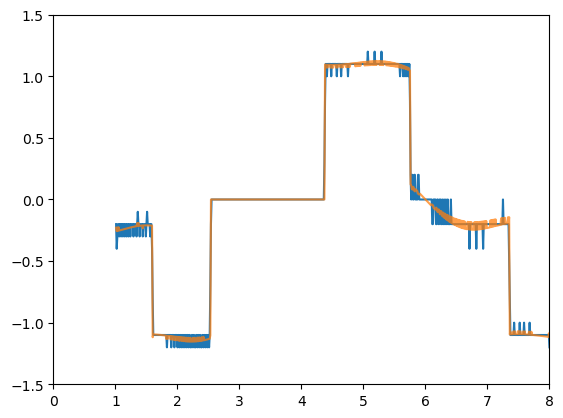

In [31]:
import matplotlib.pyplot as plt

plt.plot(t[t2], dmdt_new[300,:],label='dMdt')
#plt.plot( gmat[30,0:200]+gadv[30,0:200],label='rhs')
plt.plot(t[t2], gmat_new[300,t2]+gadv_new[300,t2] ,label='gmat',alpha=0.75)

plt.xlim(0,8)
plt.ylim(-1.5,1.5)


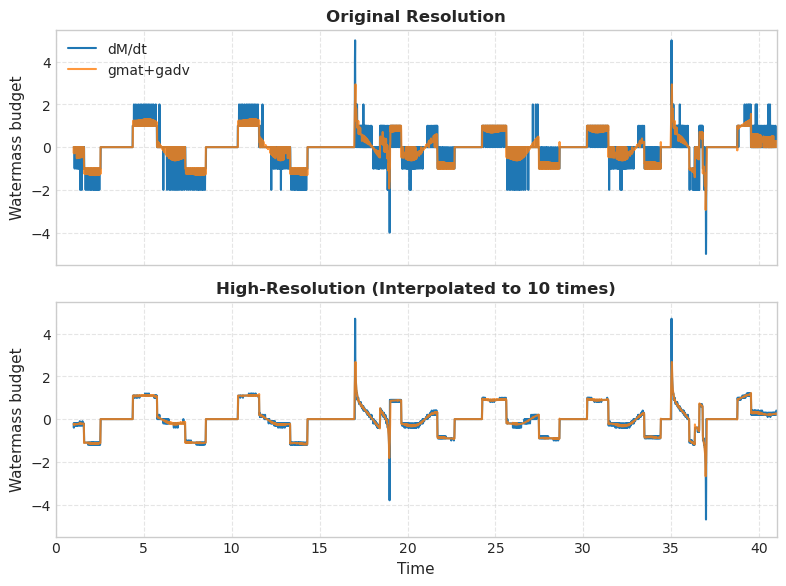

In [38]:
import matplotlib.pyplot as plt

# 设置统一风格
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True,sharey=True)

# ===================== 第一行：原始 =====================
axes[0].plot(t[t2], dmdt2[300, :], label='dM/dt', color='tab:blue', linewidth=1.5)
axes[0].plot(t[t2], gmat[300, t2] + gadv[300, t2], label='gmat+gadv', color='tab:orange', alpha=0.8, linewidth=1.5)
axes[0].set_title("Original Resolution", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Watermass budget", fontsize=11)
axes[0].legend(frameon=False, fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].set_xlim(0,41)

# ===================== 第二行：插值后 =====================
axes[1].plot(t[t2], dmdt_new[300, :], label='dM/dt (interp)', color='tab:blue', linewidth=1.5)
axes[1].plot(t[t2], gmat_new[300, t2] + gadv_new[300, t2], label='gmat+gadv (interp)', color='tab:orange', alpha=0.8, linewidth=1.5)
axes[1].set_title("High-Resolution (Interpolated to 10 times)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Time", fontsize=11)
axes[1].set_ylabel("Watermass budget", fontsize=11)
#axes[1].legend(frameon=False, fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].set_xlim(0,41)

# ===================== 统一布局 =====================
plt.tight_layout(pad=1.2)
plt.show()


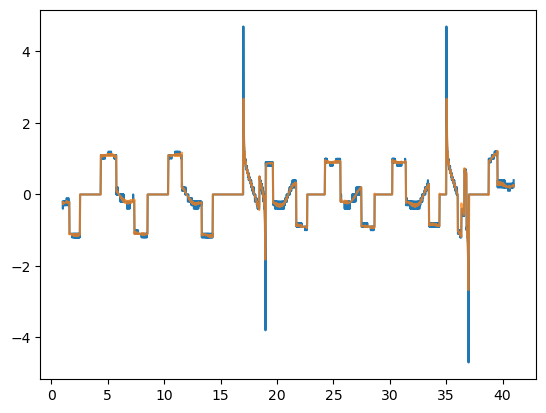

In [32]:
import matplotlib.pyplot as plt

plt.plot(t[t2], dmdt_new[300,:],label='dMdt')
plt.plot(t[t2], gmat_new[300,t2]+gadv_new[300,t2] ,label='gmat',alpha=0.75)


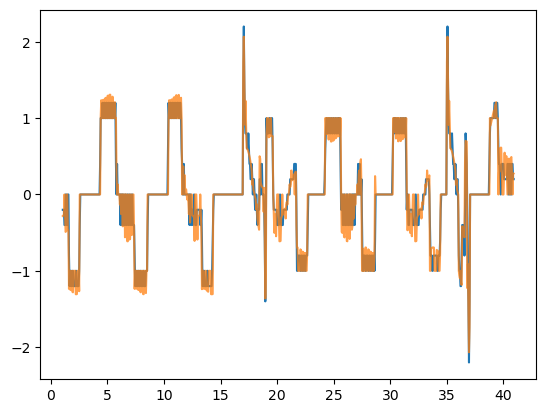

In [31]:
import matplotlib.pyplot as plt

plt.plot(t[t2], dmdt2[300,:],label='dMdt')
#plt.plot( gmat[30,0:200]+gadv[30,0:200],label='rhs')
plt.plot(t[t2], gmat[300,t2]+gadv[300,t2] ,label='gmat',alpha=0.75)



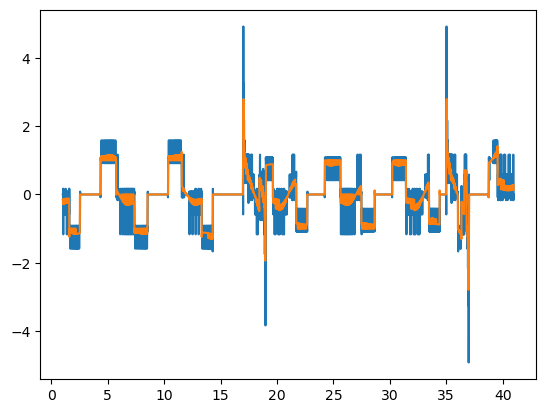

In [14]:
import matplotlib.pyplot as plt

plt.plot(t[t4], dmdt4[300,:],label='dMdt')
#plt.plot( gmat[30,0:200]+gadv[30,0:200],label='rhs')
plt.plot(t[t4], gmat[300,t4]+gadv[300,t4] ,label='gmat')



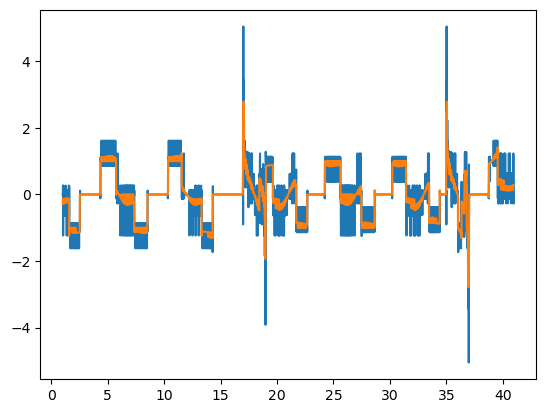

In [18]:
import matplotlib.pyplot as plt

plt.plot(t[t6], dmdt6[300,:],label='dMdt')
#plt.plot( gmat[30,0:200]+gadv[30,0:200],label='rhs')
plt.plot(t[t6], gmat[300,t6]+gadv[300,t6] ,label='gmat')



# anomaly watermass budget

In [13]:
tmean = np.zeros([int(yearlyNt),len(x)])
for i in range(int(nyear)):
    tmean = tmean + T[i*yearlyNt:i*yearlyNt+yearlyNt,:]/nyear

Tprime = T.copy()
for i in range(int(nyear)):
    Tprime[i*yearlyNt:i*yearlyNt+yearlyNt,:] = T[i*yearlyNt:i*yearlyNt+yearlyNt,:] - tmean[:,:]

Tdotmean = np.zeros([int(yearlyNt),len(x)])
for i in range(int(nyear)):
    Tdotmean = Tdotmean + Tdot[i*yearlyNt:i*yearlyNt+yearlyNt,:]/nyear

Tdotprime = Tdot.copy()
for i in range(int(nyear)):
    Tdotprime[i*yearlyNt:i*yearlyNt+yearlyNt,:] = Tdot[i*yearlyNt:i*yearlyNt+yearlyNt,:] - Tdotmean[:,:]

Txmean = np.zeros([int(yearlyNt),len(x)])
for i in range(int(nyear)):
    Txmean = Txmean + Tx[i*yearlyNt:i*yearlyNt+yearlyNt,:]/nyear

Txprime = Tdot.copy()
for i in range(int(nyear)):
    Txprime[i*yearlyNt:i*yearlyNt+yearlyNt,:] = Tx[i*yearlyNt:i*yearlyNt+yearlyNt,:] - Txmean[:,:]
    

# method - mask
## orginal data

In [14]:
dTcenters = 0.01
tcneters = np.arange(-0.5,0.5+dTcenters,dTcenters)

dmdt = np.zeros([len(tcneters),len(t)])
M    = np.zeros([len(tcneters),len(t)])
gmat = np.zeros([len(tcneters),len(t)])
gadv = np.zeros([len(tcneters),len(t)])

dTcenters = 0.01
tcneters = np.arange(-0.5,0.5+dTcenters,dTcenters)

for i in range( len(tcneters) ):
   
    M[i,:] = (Tprime >= tcneters[i]).sum(axis=1)*dx   #Tprime shape (ntime,nx)

    mask2 = Tprime >= tcneters[i]+dTcenters      # shape (ntime, nx), True 表示满足条件
    Tdotmasked = np.where(mask2, Tdotprime, 0.0)
    mat2 = (Tdotmasked*dx).sum(axis=1)   # shape (ntime,)    
    #Txmasked = np.where(mask2, Txprime, 0.0)
    #adv2 = (-Txmasked).sum(axis=1)   # shape (ntime,)  
    
    mask1 = Tprime >= tcneters[i]-dTcenters      # shape (ntime, nx), True 表示满足条件
    Tdotmasked = np.where(mask1, Tdotprime, 0.0)
    mat1 = (Tdotmasked*dx).sum(axis=1)   # shape (ntime,)   
    #Txmasked = np.where(mask1, Txprime, 0.0)
    #adv1 = (-Txmasked).sum(axis=1)   # shape (ntime,)  
    
    gmat[i,:] = -(mat2-mat1)/(dTcenters*2.)

    leftmask = (Tprime >= tcneters[i]) & (x2 == 0) 
    uu = np.ones(T.shape)
    gadv_left = (-uu*leftmask*1.).sum(axis=1)
    
    rightmask = (Tprime >= tcneters[i]) & (x2 == 3) 
    gadv_right = (-uu*rightmask*1.).sum(axis=1)
    
    gadv[i,:] = gadv_right - gadv_left

    
dmdt = (M[:,1:]-M[:,0:-1])/dt

# method - mask
## high-resolution data

In [15]:
tmean = np.zeros([int(yearlyNt),len(x_new)])
for i in range(int(nyear)):
    tmean = tmean + T_new[i*yearlyNt:i*yearlyNt+yearlyNt,:]/nyear

Tprime = T_new.copy()
for i in range(int(nyear)):
    Tprime[i*yearlyNt:i*yearlyNt+yearlyNt,:] = T_new[i*yearlyNt:i*yearlyNt+yearlyNt,:] - tmean[:,:]

Tdotmean = np.zeros([int(yearlyNt),len(x_new)])
for i in range(int(nyear)):
    Tdotmean = Tdotmean + Tdot_new[i*yearlyNt:i*yearlyNt+yearlyNt,:]/nyear

Tdotprime = Tdot_new.copy()
for i in range(int(nyear)):
    Tdotprime[i*yearlyNt:i*yearlyNt+yearlyNt,:] = Tdot_new[i*yearlyNt:i*yearlyNt+yearlyNt,:] - Tdotmean[:,:]

Txmean = np.zeros([int(yearlyNt),len(x_new)])
for i in range(int(nyear)):
    Txmean = Txmean + Tx_new[i*yearlyNt:i*yearlyNt+yearlyNt,:]/nyear

Txprime = Tdot_new.copy()
for i in range(int(nyear)):
    Txprime[i*yearlyNt:i*yearlyNt+yearlyNt,:] = Tx_new[i*yearlyNt:i*yearlyNt+yearlyNt,:] - Txmean[:,:]

In [16]:
dTcenters = 0.01
tcneters = np.arange(-0.5,0.5+dTcenters,dTcenters)

dmdt_new = np.zeros([len(tcneters),len(t)])
M    = np.zeros([len(tcneters),len(t)])
gmat_new = np.zeros([len(tcneters),len(t)])
gadv_new = np.zeros([len(tcneters),len(t)])

dTcenters = 0.01
tcneters = np.arange(-0.5,0.5+dTcenters,dTcenters)

for i in range( len(tcneters) ):
   
    M[i,:] = (Tprime >= tcneters[i]).sum(axis=1)*dx_new   #Tprime shape (ntime,nx)

    mask2 = Tprime >= tcneters[i]+dTcenters      # shape (ntime, nx), True 表示满足条件
    Tdotmasked = np.where(mask2, Tdotprime, 0.0)
    mat2 = (Tdotmasked*dx_new).sum(axis=1)   # shape (ntime,)    
    #Txmasked = np.where(mask2, Txprime, 0.0)
    #adv2 = (-Txmasked).sum(axis=1)   # shape (ntime,)  
    
    mask1 = Tprime >= tcneters[i]-dTcenters      # shape (ntime, nx), True 表示满足条件
    Tdotmasked = np.where(mask1, Tdotprime, 0.0)
    mat1 = (Tdotmasked*dx_new).sum(axis=1)   # shape (ntime,)   
    #Txmasked = np.where(mask1, Txprime, 0.0)
    #adv1 = (-Txmasked).sum(axis=1)   # shape (ntime,)  
    
    gmat_new[i,:] = -(mat2-mat1)/dTcenters/2.

    leftmask = (Tprime >= tcneters[i]) & (x2_new == 0) 
    uu = np.ones(T_new.shape)
    gadv_left = (-uu*leftmask*1.).sum(axis=1)
    
    rightmask = (Tprime >= tcneters[i]) & (x2_new == 3) 
    gadv_right = (-uu*rightmask*1.).sum(axis=1)
    
    gadv_new[i,:] = gadv_right - gadv_left

    
dmdt_new = (M[:,1:]-M[:,0:-1])/dt

# see

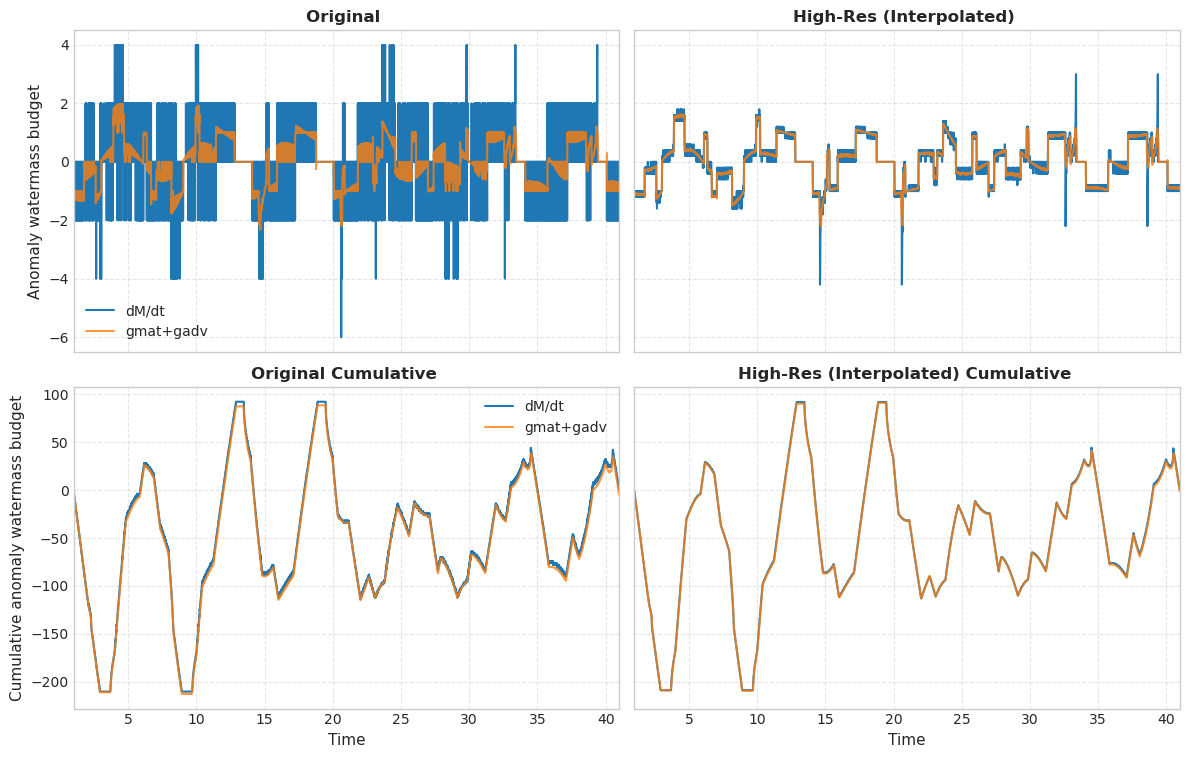

In [86]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')

# 创建 2x2 图，sharex=True 共享列的 x 轴，sharey='row' 每行共享 y 轴
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey='row')

# 设置 x 轴范围
xlim = (1, 41)

# ===================== 左上：原始 dmdt vs gmat =====================
axes[0, 0].plot(t[0:-1], dmdt[10, 0:], label='dM/dt', color='tab:blue', linewidth=1.5)
axes[0, 0].plot(t[0:-1], gmat[10, 0:-1] + gadv[10, 0:-1], label='gmat+gadv', color='tab:orange', alpha=0.8, linewidth=1.5)
axes[0, 0].set_title("Original ", fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel("Anomaly watermass budget", fontsize=11)
axes[0, 0].legend(frameon=False, fontsize=10)
axes[0, 0].grid(True, linestyle='--', alpha=0.5)
axes[0, 0].set_xlim(*xlim)

# ===================== 右上：插值后 dmdt vs gmat =====================
axes[0, 1].plot(t[0:-1], dmdt_new[10, 0:], color='tab:blue', linewidth=1.5)
axes[0, 1].plot(t[0:-1], gmat_new[10, 0:-1] + gadv_new[10, 0:-1], color='tab:orange', alpha=0.8, linewidth=1.5)
axes[0, 1].set_title("High-Res (Interpolated) ", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, linestyle='--', alpha=0.5)
axes[0, 1].set_xlim(*xlim)

# ===================== 左下：原始累积 =====================
axes[1, 0].plot(t[0:-1], np.cumsum(dmdt[40, :]), label='dM/dt', color='tab:blue', linewidth=1.5)
axes[1, 0].plot(t[0:-1], np.cumsum(gmat[40, 0:-1] + gadv[40, 0:-1]), label='gmat+gadv', color='tab:orange', alpha=0.8, linewidth=1.5)
axes[1, 0].set_title("Original Cumulative ", fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel("Cumulative anomaly watermass budget", fontsize=11)
axes[1, 0].set_xlabel("Time", fontsize=11)
axes[1, 0].legend(frameon=False, fontsize=10)
axes[1, 0].grid(True, linestyle='--', alpha=0.5)
axes[1, 0].set_xlim(*xlim)

# ===================== 右下：插值后累积 =====================
axes[1, 1].plot(t[0:-1], np.cumsum(dmdt_new[40, :]), color='tab:blue', linewidth=1.5)
axes[1, 1].plot(t[0:-1], np.cumsum(gmat_new[40, 0:-1] + gadv_new[40, 0:-1]), color='tab:orange', alpha=0.8, linewidth=1.5)
axes[1, 1].set_title("High-Res (Interpolated) Cumulative ", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Time", fontsize=11)
axes[1, 1].grid(True, linestyle='--', alpha=0.5)
axes[1, 1].set_xlim(*xlim)

# ===================== 整体标题 =====================
#fig.suptitle("Watermass Budget: Original vs High-Res Interpolated", fontsize=14, fontweight='bold')

# 调整布局
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 上方留给 suptitle
plt.show()


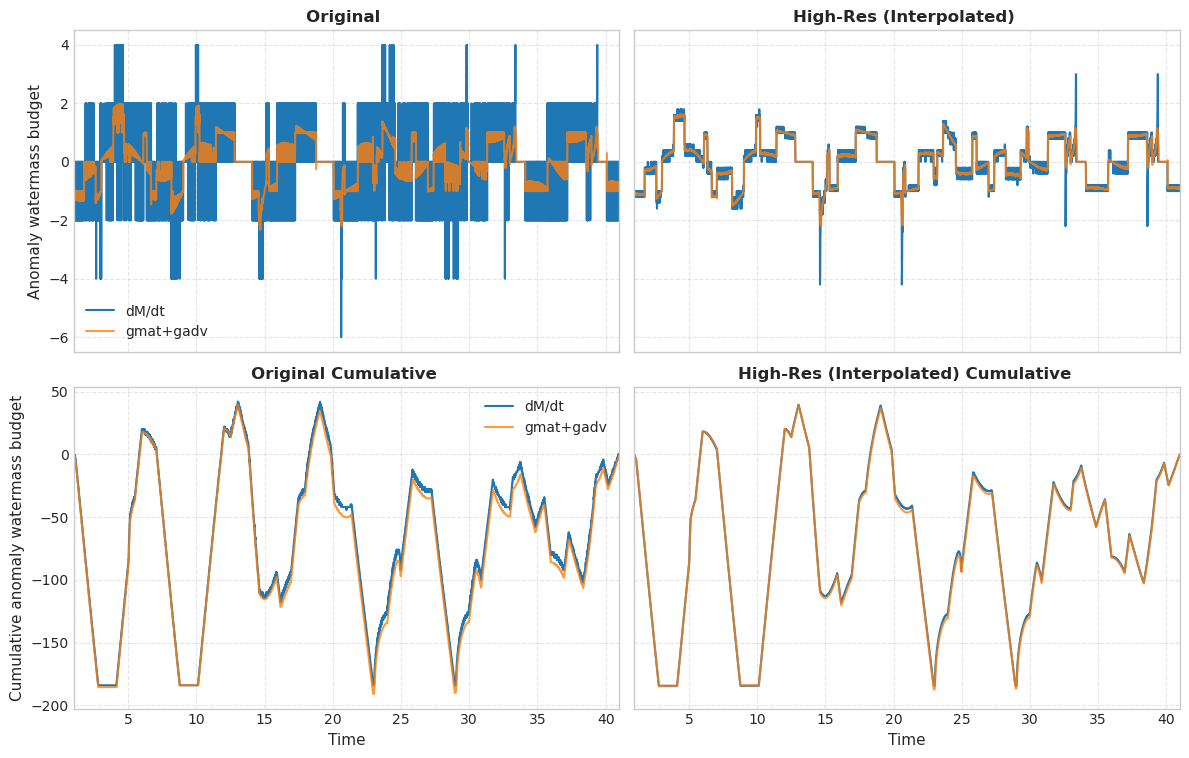

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')

# 创建 2x2 图，sharex=True 共享列的 x 轴，sharey='row' 每行共享 y 轴
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey='row')

# 设置 x 轴范围
xlim = (1, 41)

# ===================== 左上：原始 dmdt vs gmat =====================
axes[0, 0].plot(t[0:-1], dmdt[10, 0:], label='dM/dt', color='tab:blue', linewidth=1.5)
axes[0, 0].plot(t[0:-1], gmat[10, 0:-1] + gadv[10, 0:-1], label='gmat+gadv', color='tab:orange', alpha=0.8, linewidth=1.5)
axes[0, 0].set_title("Original ", fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel("Anomaly watermass budget", fontsize=11)
axes[0, 0].legend(frameon=False, fontsize=10)
axes[0, 0].grid(True, linestyle='--', alpha=0.5)
axes[0, 0].set_xlim(*xlim)

# ===================== 右上：插值后 dmdt vs gmat =====================
axes[0, 1].plot(t[0:-1], dmdt_new[10, 0:], color='tab:blue', linewidth=1.5)
axes[0, 1].plot(t[0:-1], gmat_new[10, 0:-1] + gadv_new[10, 0:-1], color='tab:orange', alpha=0.8, linewidth=1.5)
axes[0, 1].set_title("High-Res (Interpolated) ", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, linestyle='--', alpha=0.5)
axes[0, 1].set_xlim(*xlim)

# ===================== 左下：原始累积 =====================
axes[1, 0].plot(t[0:-1], np.cumsum(dmdt[80, :]), label='dM/dt', color='tab:blue', linewidth=1.5)
axes[1, 0].plot(t[0:-1], np.cumsum(gmat[80, 0:-1] + gadv[80, 0:-1]), label='gmat+gadv', color='tab:orange', alpha=0.8, linewidth=1.5)
axes[1, 0].set_title("Original Cumulative ", fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel("Cumulative anomaly watermass budget", fontsize=11)
axes[1, 0].set_xlabel("Time", fontsize=11)
axes[1, 0].legend(frameon=False, fontsize=10)
axes[1, 0].grid(True, linestyle='--', alpha=0.5)
axes[1, 0].set_xlim(*xlim)

# ===================== 右下：插值后累积 =====================
axes[1, 1].plot(t[0:-1], np.cumsum(dmdt_new[80, :]), color='tab:blue', linewidth=1.5)
axes[1, 1].plot(t[0:-1], np.cumsum(gmat_new[80, 0:-1] + gadv_new[80, 0:-1]), color='tab:orange', alpha=0.8, linewidth=1.5)
axes[1, 1].set_title("High-Res (Interpolated) Cumulative ", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Time", fontsize=11)
axes[1, 1].grid(True, linestyle='--', alpha=0.5)
axes[1, 1].set_xlim(*xlim)

# ===================== 整体标题 =====================
#fig.suptitle("Watermass Budget: Original vs High-Res Interpolated", fontsize=14, fontweight='bold')

# 调整布局
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 上方留给 suptitle
plt.show()

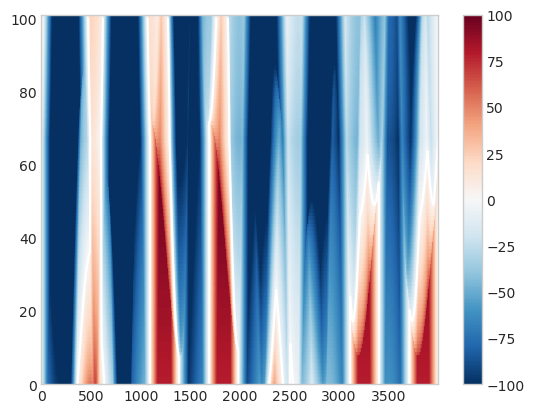

In [28]:
plt.pcolor(np.cumsum(dmdt_new[:, :], axis=1) , vmin=-100, vmax=100, cmap="RdBu_r")
plt.colorbar()
plt.contour(np.cumsum(dmdt_new[:, :], axis=1), levels=[0])

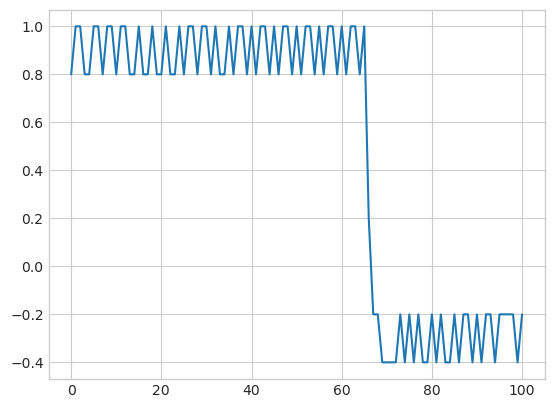

In [27]:
plt.plot(np.cumsum(dmdt_new[:, :], axis=1)[:,-1])

ValueError: not enough values to unpack (expected 2, got 1)

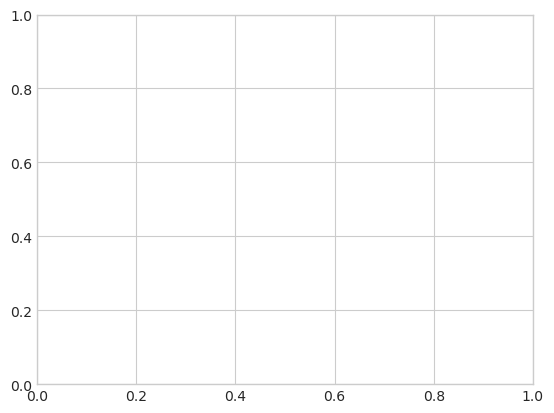

In [19]:
plt.pcolor(np.cumsum(gmat_new[:, 0:-1] + gadv_new[:, 0:-1]) )

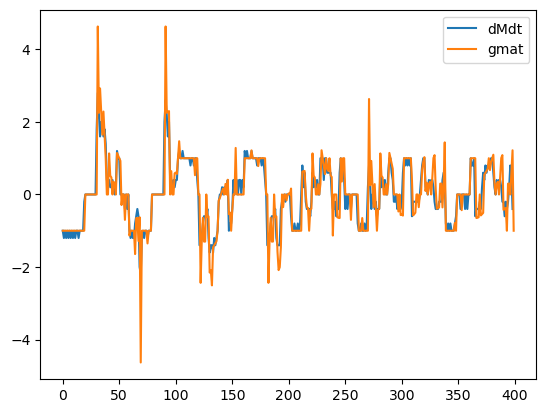

In [39]:
import matplotlib.pyplot as plt

plt.plot( dmdt[10,0:],label='dMdt')
plt.plot( gmat[10,0:]+gadv[10,0:],label='gmat')
plt.legend()


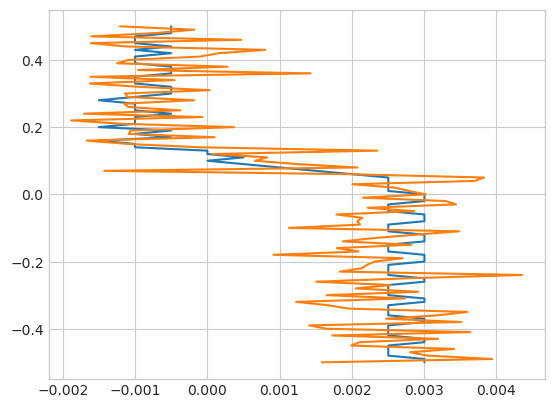

In [29]:
plt.plot(np.mean(dmdt[:,:-11],1),tcneters)
plt.plot(np.mean(gmat[:,0:-11]+gadv[:,0:-11],1),tcneters)
#plt.plot(np.mean(gadv[:,0:-1],1),tcneters)


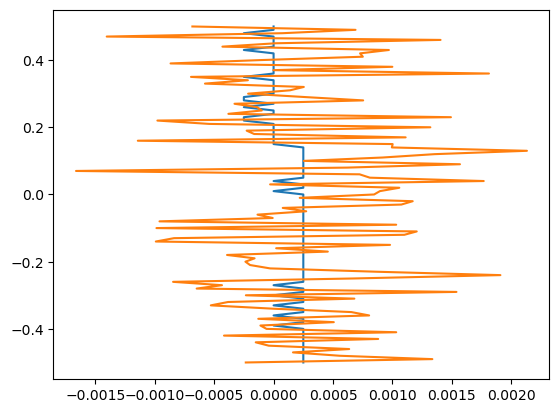

In [52]:
plt.plot(np.mean(dmdt,1),tcneters)
plt.plot(np.mean(gmat[:,0:-1]+gadv[:,0:-1],1),tcneters)
#plt.plot(np.mean(gadv[:,0:-1],1),tcneters)


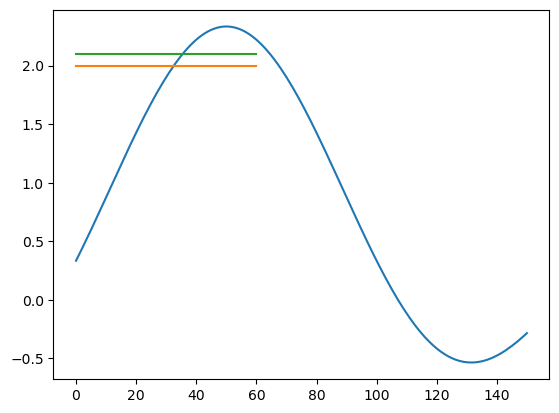

In [186]:
plt.plot(Tprime[50,:])
plt.plot([0,60],[2.0,2.0])
plt.plot([0,60],[2.1,2.1])

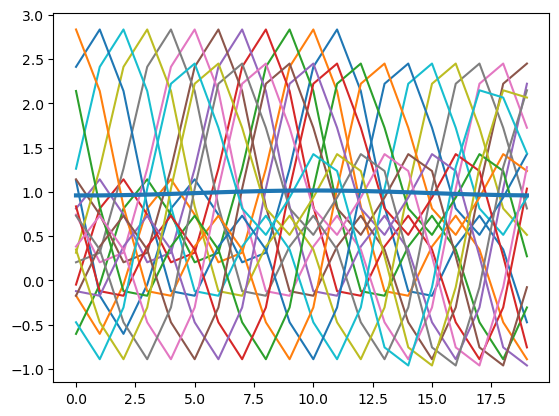

In [152]:
for i in range(20):
    plt.plot( T[i:i+20,10] )
plt.plot( tmean[:,10],linewidth=3 )


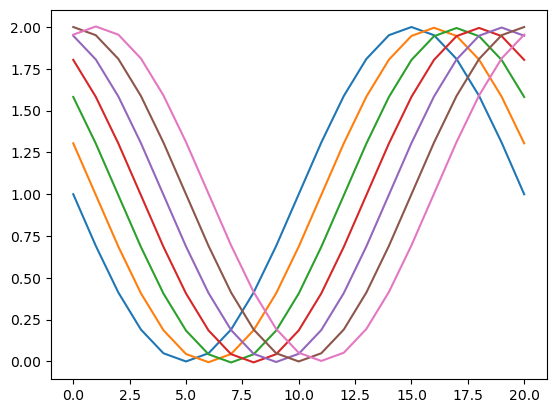

In [45]:
import matplotlib.pyplot as plt

plt.plot(T[0,:])
plt.plot(T[1,:])
plt.plot(T[2,:])
plt.plot(T[3,:])
plt.plot(T[4,:])
plt.plot(T[5,:])
plt.plot(T[6,:])


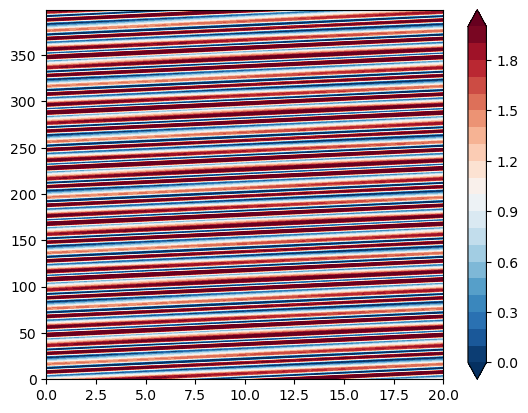

In [140]:
plt.contourf(T, levels=np.arange(0,2.1,0.1),extend='both',cmap='RdBu_r' )
plt.colorbar()


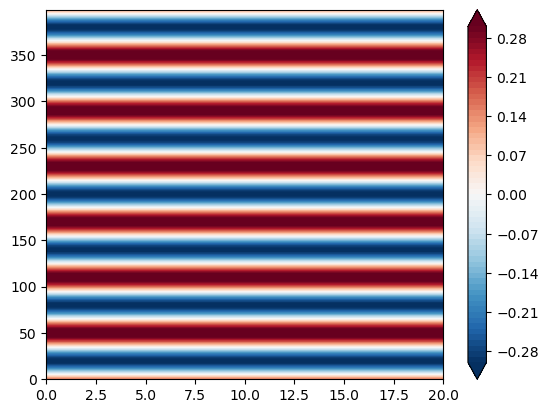

In [145]:
plt.contourf(Tprime, levels=np.arange(-0.3,0.31,0.01),extend='both',cmap='RdBu_r' )
plt.colorbar()


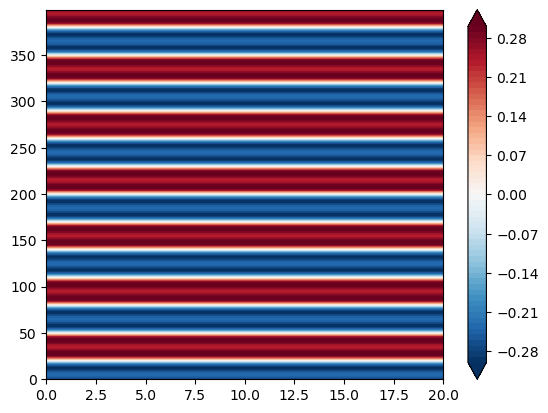

In [128]:
plt.contourf(Tdot, levels=np.arange(-0.3,0.31,0.01),extend='both',cmap='RdBu_r' )
plt.colorbar()

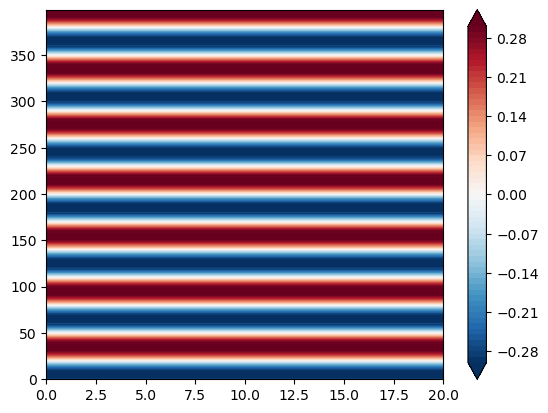

In [127]:
plt.contourf(Tdotprime, levels=np.arange(-0.3,0.31,0.01),extend='both',cmap='RdBu_r' )
plt.colorbar()